In [2]:

# Data manipulation and analysis
import os
import re
import json
import csv
import urllib.request
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from PIL import Image
from io import BytesIO

# Geospatial data processing
from shapely.geometry import Point, LineString, Polygon, LinearRing
from shapely.geometry import shape, MultiPolygon, MultiLineString, MultiPoint
import networkx as nx

# Machine learning and data preprocessing
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from scipy.stats import gaussian_kde
import shap

# Utility
import joblib
from glob import glob
from ChangeCoordinate import ChangeCoord
import requests



data

In [3]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs(epsg=27700)

ward_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
ward_shp = ward_shp.to_crs(epsg=27700)

borough_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
borough_shp = borough_shp.to_crs(epsg=27700)

msoa_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
msoa_shp = msoa_shp.to_crs(epsg=27700)

In [4]:
msoa_origin_similarity = msoa_shp.copy()
msoa_destination_similarity = msoa_shp.copy()

In [5]:
MSOA_origin_PDFs_matrix = pd.read_csv('output/MSOA_origin_PDFs_matrix.csv', index_col=0)
MSOA_destination_PDFs_matrix = pd.read_csv('output/MSOA_des_PDFs_matrix.csv', index_col=0)

In [6]:
# add a new column 'similarity_index' to the msoa_origin_similarity
msoa_origin_similarity['similarity_index'] = 0.00
# add a new column 'adjacent_ele_list' to the msoa_origin_similarity
msoa_origin_similarity['adjacent_ele_list'] = ""
msoa_origin_similarity['adjacent_2level_list'] = ""

# for each row in the msoa_origin_similarity, calculate all adjacent shapefile elements and calculate the average similarity index based on the MSOA_origin_PDFs_matrix
for index, row in msoa_origin_similarity.iterrows():
    # get tjhe MSOA code of the current row
    MSOAcode = row['MSOA11CD']
    # get the adjacent shapefile elements of the current row, which means whichever share the boundary with the current row
    adjacent = msoa_origin_similarity[msoa_origin_similarity.geometry.intersects(row['geometry'])]
    # for each element in the adjacent shapefile elements, get all the adjacent shapefile elements of them, which means the 2-level adjacent elements
    # also, the results should not contain the elements already in the adjacent shapefile elements, also exclude the current row itself
    adjacent_2level = msoa_origin_similarity[msoa_origin_similarity.geometry.intersects(adjacent['geometry'].unary_union) & ~msoa_origin_similarity.geometry.intersects(row['geometry']) & ~msoa_origin_similarity['MSOA11CD'].isin(adjacent['MSOA11CD'])]
    
    # convert the 'MSOA11CD' column of the adjacent shapefile elements to a list and save it to the 'adjacent_ele_list' column of the current row
    msoa_origin_similarity.at[index, 'adjacent_ele_list'] = adjacent['MSOA11CD'].tolist()
    # convert the 'MSOA11CD' column of the 2-level adjacent shapefile elements to a list and save it to the 'adjacent_2level_list' column of the current row
    msoa_origin_similarity.at[index, 'adjacent_2level_list'] = adjacent_2level['MSOA11CD'].tolist()
    # for each adjacent shapefile element, calculate the similarity index based on the MSOA_origin_PDFs_matrix
    similarity_index_level1 = 0
    similarity_index_level2 = 0
    for index_adj, row_adj in adjacent.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level1 += MSOA_origin_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
        
    for index_adj, row_adj in adjacent_2level.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level2 += MSOA_origin_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
    alpha_level1 = 1
    alpha_level2 = 0.5
    # calculate the average similarity index
    similarity_index = (similarity_index_level1 / len(adjacent)) * alpha_level1 + (similarity_index_level2 / len(adjacent_2level)) * alpha_level2
    # fill the similarity index into the msoa_origin_similarity
    msoa_origin_similarity.loc[index, 'similarity_index'] = similarity_index
    
msoa_origin_similarity.sample(4)

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,similarity_index,adjacent_ele_list,adjacent_2level_list
540,E02000561,Islington 008,E09000019,Islington,E12000007,London,7746,7632,114,126.3,3413,2.2,"POLYGON ((530135.625 186350.969, 530211.533 18...",0.175051,"[E02000168, E02000174, E02000556, E02000557, E...","[E02000166, E02000172, E02000180, E02000184, E..."
945,E02000978,Westminster 019,E09000033,Westminster,E12000007,London,9270,7862,1408,25.8,3882,2.0,"POLYGON ((528427.719 180115.109, 528410.126 17...",0.116649,"[E02000584, E02000586, E02000588, E02000592, E...","[E02000001, E02000186, E02000193, E02000582, E..."
91,E02000094,Brent 002,E09000005,Brent,E12000007,London,8746,8640,106,75.2,2738,3.2,"POLYGON ((520761.781 189633.781, 520893.848 18...",0.183672,"[E02000047, E02000053, E02000059, E02000093, E...","[E02000041, E02000044, E02000048, E02000049, E..."
129,E02000133,Bromley 007,E09000006,Bromley,E12000007,London,9606,9403,203,16.1,3961,2.4,"POLYGON ((542258.907 171381.442, 542375.308 17...",0.131802,"[E02000127, E02000128, E02000133, E02000136, E...","[E02000089, E02000090, E02000091, E02000134, E..."


In [7]:
msoa_destination_similarity['similarity_index'] = 0.00
msoa_destination_similarity['adjacent_ele_list'] = ""
msoa_destination_similarity['adjacent_2level_list'] = ""

for index, row in msoa_destination_similarity.iterrows():
    MSOAcode = row['MSOA11CD']
    adjacent = msoa_destination_similarity[msoa_destination_similarity.geometry.intersects(row['geometry'])]
    adjacent_2level = msoa_destination_similarity[msoa_destination_similarity.geometry.intersects(adjacent['geometry'].unary_union) & ~msoa_destination_similarity.geometry.intersects(row['geometry']) & ~msoa_destination_similarity['MSOA11CD'].isin(adjacent['MSOA11CD'])]
    msoa_destination_similarity.at[index, 'adjacent_ele_list'] = adjacent['MSOA11CD'].tolist()
    msoa_destination_similarity.at[index, 'adjacent_2level_list'] = adjacent_2level['MSOA11CD'].tolist()
    similarity_index_level1 = 0
    similarity_index_level2 = 0
    for index_adj, row_adj in adjacent.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level1 += MSOA_destination_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
        
    for index_adj, row_adj in adjacent_2level.iterrows():
        MSOAcode_adj = row_adj['MSOA11CD']
        similarity_index_level2 += MSOA_destination_PDFs_matrix.loc[MSOAcode, MSOAcode_adj]
    alpha_level1 = 1
    alpha_level2 = 0.5
    similarity_index = (similarity_index_level1 / len(adjacent)) * alpha_level1 + (similarity_index_level2 / len(adjacent_2level)) * alpha_level2
    msoa_destination_similarity.loc[index, 'similarity_index'] = similarity_index
    
msoa_destination_similarity.sample(4)


,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,similarity_index,adjacent_ele_list,adjacent_2level_list
777,E02000807,Southwark 001,E09000028,Southwark,E12000007,London,8313,8305,8,116.8,3705,2.2,"POLYGON ((536516.400 180437.000, 536609.880 18...",0.131199,"[E02000807, E02000813, E02000814]","[E02000653, E02000810, E02000817]"
136,E02000140,Bromley 014,E09000006,Bromley,E12000007,London,8041,8041,0,42.6,3301,2.4,"POLYGON ((546752.625 170419.625, 547047.188 17...",0.136629,"[E02000091, E02000092, E02000136, E02000140, E...","[E02000087, E02000088, E02000090, E02000128, E..."
626,E02000648,Lambeth 031,E09000022,Lambeth,E12000007,London,7791,7683,108,110.6,3232,2.4,"POLYGON ((532774.512 171734.107, 532798.000 17...",0.150722,"[E02000195, E02000645, E02000647, E02000648, E...","[E02000131, E02000194, E02000196, E02000197, E..."
680,E02000705,Merton 017,E09000024,Merton,E12000007,London,8124,8083,41,65.4,2836,2.9,"POLYGON ((529955.500 169800.891, 530290.750 16...",0.139421,"[E02000197, E02000652, E02000702, E02000705, E...","[E02000196, E02000202, E02000204, E02000209, E..."


plot

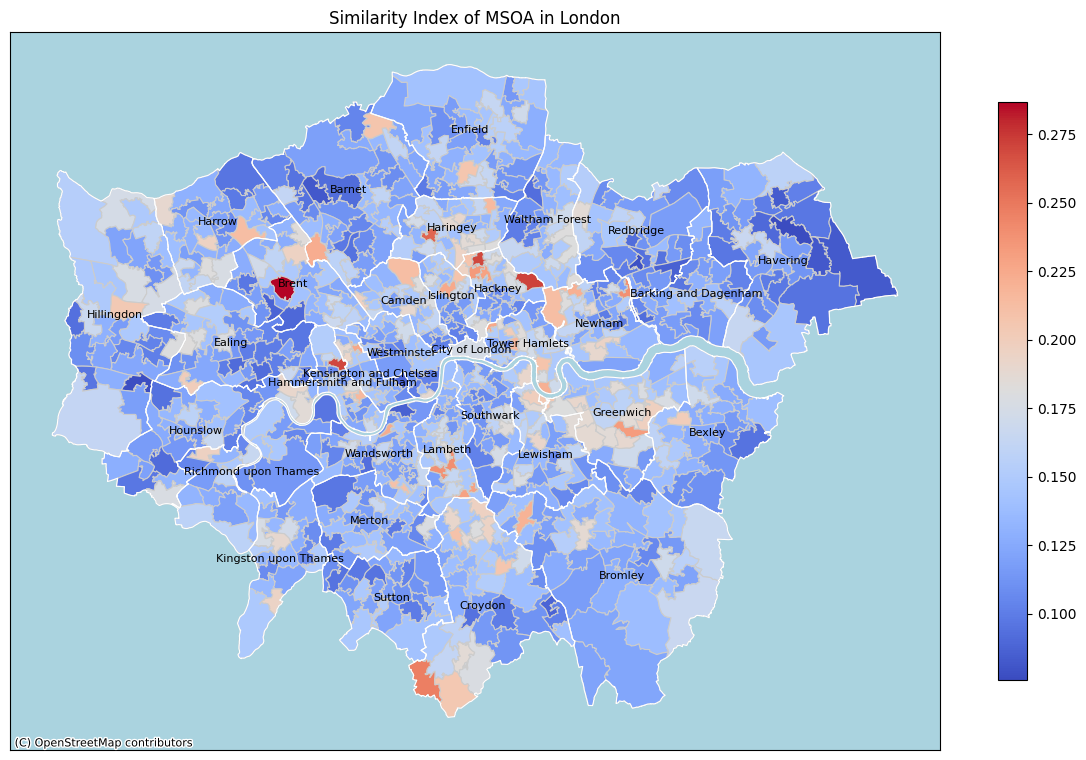

<Figure size 640x480 with 0 Axes>

In [8]:
#plot the msoa_shp with coloring each MSOA based on the 'similarity_index' column
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_origin_similarity.plot(column='similarity_index', cmap='coolwarm', 
                            linewidth=0.8, ax=ax, edgecolor='0.8',
                            legend=True, legend_kwds={'shrink': 0.5})

# plot the borough_shp, set the edgecolor to white and linewidth to 0.8
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
# label each borough with ;'NAME' columne
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')

# add a basemap from open street map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.xticks([])
plt.yticks([])
# set the title of the plot
plt.title('Similarity Index of MSOA in London')
plt.show()
plt.savefig('output/similarity_index_msoa_origin.png')

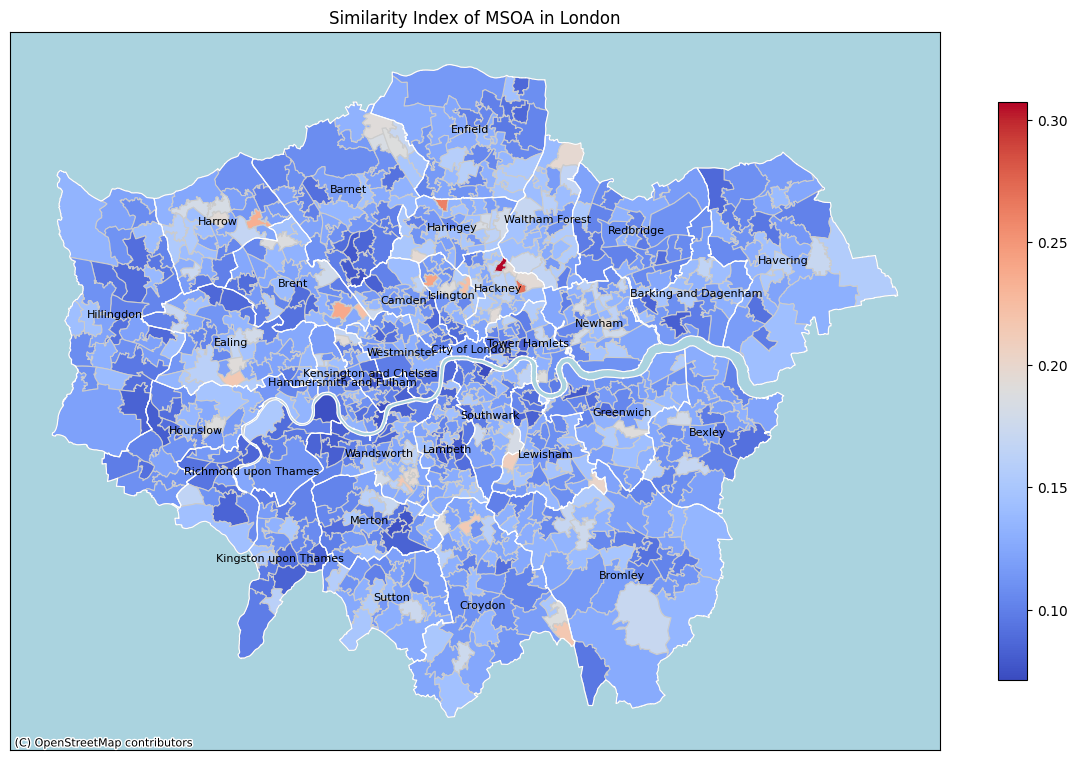

<Figure size 640x480 with 0 Axes>

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_destination_similarity.plot(column='similarity_index', cmap='coolwarm', 
                            linewidth=0.8, ax=ax, edgecolor='0.8',
                            legend=True, legend_kwds={'shrink': 0.5})

borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')
    
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.xticks([])
plt.yticks([])
plt.title('Similarity Index of MSOA in London')
plt.show()
plt.savefig('output/similarity_index_msoa_destination.png')

## regression

In [24]:
census_data = pd.read_csv('data/msoa_census_data.csv', encoding='latin1')

In [25]:

# combine the census_data with the msoa_origin_similarity based on census_data['Middle Super Output Area'] with msoa_origin_similarity['MSOA11CD']
census_origin_msoa_raw = census_data.merge(msoa_origin_similarity, left_on='Middle Super Output Area', right_on='MSOA11CD', how='left')


In [26]:
# drop the NaN value in the 'Middle Super Output Area' column
census_origin_msoa.dropna(subset=['Middle Super Output Area'], inplace=True)
census_origin_msoa

,Middle Super Output Area,MSOA Name,Age Structure (2011 Census);All Ages;,Age Structure (2011 Census);0-15;,Age Structure (2011 Census);16-29;,Age Structure (2011 Census);30-44;,Age Structure (2011 Census);45-64;,Age Structure (2011 Census);65+;,Age Structure (2011 Census);Working-age;,Mid-year Estimate totals;All Ages;2002,...,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,similarity_index,adjacent_ele_list,adjacent_2level_list
0,E02000001,City of London 001,7375,620,1665,2045,2010,1035,5720,7280,...,7375.0,7187.0,188.0,25.5,4385.0,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",0.174155,"[E02000001, E02000192, E02000193, E02000371, E...","[E02000189, E02000190, E02000191, E02000368, E..."
1,E02000002,Barking and Dagenham 001,6775,1751,1277,1388,1258,1101,3923,6333,...,6775.0,6724.0,51.0,31.3,2713.0,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.133092,"[E02000002, E02000003, E02000468, E02000474, E...","[E02000005, E02000466, E02000472, E02000476, E..."
2,E02000003,Barking and Dagenham 002,10045,2247,1959,2300,2259,1280,6518,9236,...,10045.0,10033.0,12.0,46.9,3834.0,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",0.116413,"[E02000002, E02000003, E02000005, E02000474, E...","[E02000004, E02000007, E02000008, E02000009, E..."
3,E02000004,Barking and Dagenham 003,6182,1196,1277,1154,1543,1012,3974,6208,...,6182.0,5937.0,245.0,24.8,2318.0,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",0.102412,"[E02000004, E02000007, E02000011, E02000480, E...","[E02000003, E02000005, E02000008, E02000010, E..."
4,E02000005,Barking and Dagenham 004,8562,2200,1592,1995,1829,946,5416,7919,...,8562.0,8562.0,0.0,72.1,3183.0,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.117575,"[E02000003, E02000005, E02000007, E02000008, E...","[E02000002, E02000004, E02000009, E02000010, E..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02000979,Westminster 020,8081,1028,1988,2132,1969,964,6089,8604,...,8081.0,7317.0,764.0,58.1,3892.0,1.9,"POLYGON ((530378.200 180095.200, 530281.305 17...",0.102266,"[E02000977, E02000978, E02000979, E02000980, E...","[E02000001, E02000193, E02000584, E02000586, E..."
979,E02000980,Westminster 021,8684,1277,1946,2317,1993,1151,6256,7780,...,8684.0,8626.0,58.0,193.7,4498.0,1.9,"POLYGON ((530125.935 178985.975, 530281.305 17...",0.104061,"[E02000979, E02000980, E02000981, E02000983]","[E02000977, E02000978, E02000982]"
980,E02000981,Westminster 022,8991,913,2475,2781,1969,853,7225,8745,...,8991.0,8866.0,125.0,247.2,4853.0,1.8,"POLYGON ((529298.222 178707.616, 529395.381 17...",0.137612,"[E02000979, E02000980, E02000981, E02000982, E...","[E02000594, E02000977, E02000978]"
981,E02000982,Westminster 023,8226,1446,1689,2154,1835,1102,5678,7719,...,8226.0,8198.0,28.0,126.0,4143.0,2.0,"POLYGON ((528984.884 178747.856, 528904.275 17...",0.099073,"[E02000594, E02000978, E02000979, E02000981, E...","[E02000584, E02000586, E02000588, E02000590, E..."


In [27]:
census_columns = census_data.columns.tolist()


### X

In [28]:
# select the columns in the census_origin_msoa
columns_to_select = ['Ethnic Group (2011 Census);White (%);',
                     'Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);',
                     'House Prices;Median House Price (£);2013 (p)',
                     'Qualifications (2011 Census);Schoolchildren and full-time students: Age 18 and over;',
                     'Household Income Estimates (2011/12);Total Median Annual Household Income (£);']
                     
X_origin_msoa_raw = census_origin_msoa[columns_to_select]


In [82]:
# min-max scale the X_origin_msoa_raw
minmax_scaler = MinMaxScaler()
X_origin_msoa = minmax_scaler.fit_transform(X_origin_msoa_raw)
X_origin_msoa = pd.DataFrame(X_origin_msoa, columns=columns_to_select)
X_origin_msoa

,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,House Prices;Median House Price (£);2013 (p),Qualifications (2011 Census);Schoolchildren and full-time students: Age 18 and over;,Household Income Estimates (2011/12);Total Median Annual Household Income (£);
0,0.804661,0.318182,0.138763,0.092365,0.400854
1,0.653718,0.431818,0.016591,0.046182,0.127300
2,0.538291,0.363636,0.030769,0.098522,0.262850
3,0.831299,0.215909,0.022624,0.028633,0.302131
4,0.668147,0.295455,0.013575,0.064963,0.156376
...,...,...,...,...,...
978,0.749168,0.397727,0.200588,0.141010,0.463693
979,0.685905,0.409091,0.151508,0.111761,0.262476
980,0.810211,0.318182,0.149321,0.152401,0.469489
981,0.645949,0.420455,0.236802,0.109914,0.236297


<Axes: >

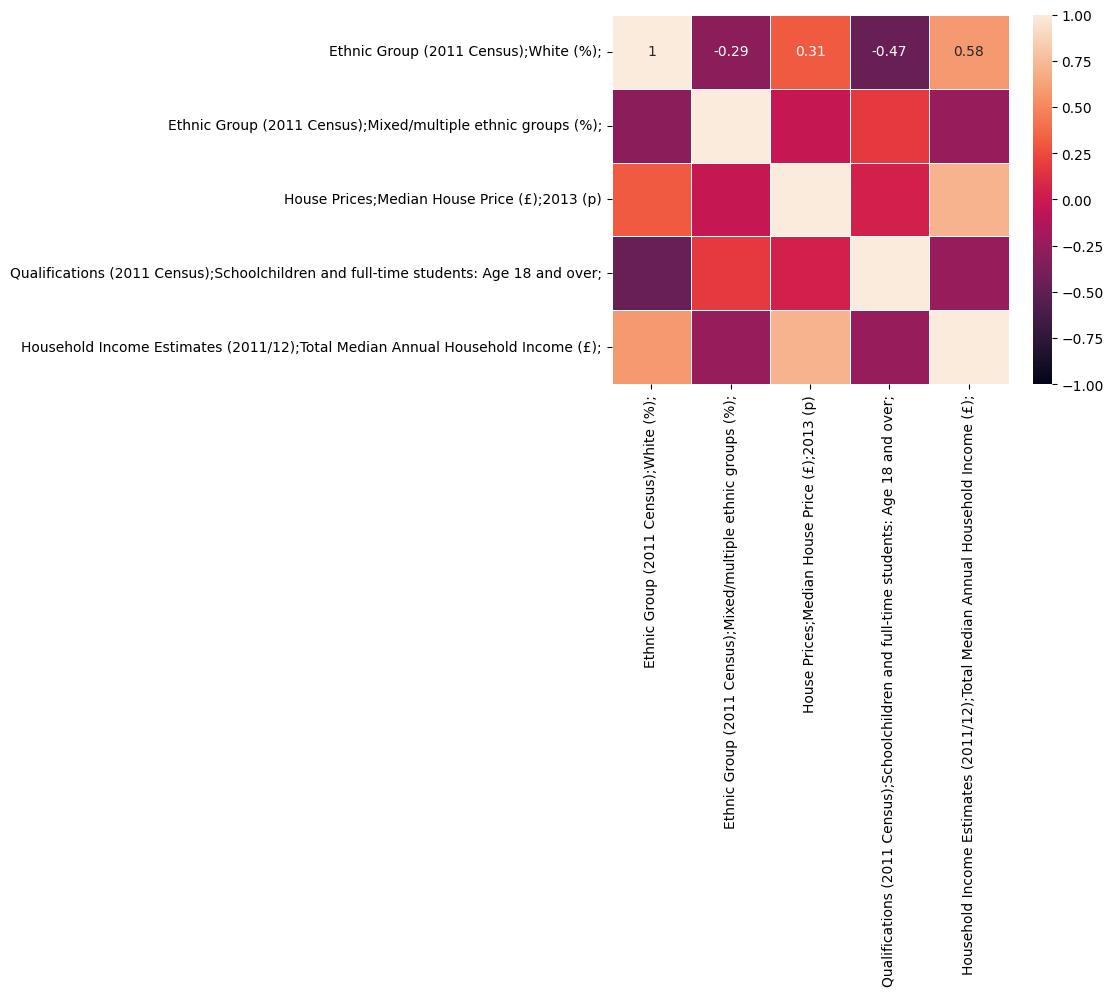

In [30]:
sns.heatmap(X_origin_msoa.corr(), annot=True,
            linecolor='white', linewidth=0.5, 
            vmin=-1, vmax=1)
            

### Y

In [42]:
Y_origin_msoa = census_origin_msoa['similarity_index']
Y_origin_msoa

0      0.174155
1      0.133092
2      0.116413
3      0.102412
4      0.117575
         ...   
978    0.102266
979    0.104061
980    0.137612
981    0.099073
982    0.188449
Name: similarity_index, Length: 983, dtype: float64

In [44]:
# min max scale the Y_origin_msoa
scaler = MinMaxScaler()
Y_origin_msoa = scaler.fit_transform(Y_origin_msoa.values.reshape(-1, 1))
Y_origin_msoa = pd.DataFrame(Y_origin_msoa, columns=['similarity_index'])
Y_origin_msoa


,similarity_index
0,0.466378
1,0.271522
2,0.192377
3,0.125941
4,0.197893
...,...
978,0.125249
979,0.133766
980,0.292972
981,0.110096


## GBDT

In [51]:
X_origin_msoa.shape, Y_origin_msoa.shape

((983, 5), (983, 1))

In [52]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_origin_msoa, Y_origin_msoa, test_size=0.2, random_state=42, shuffle=True)


In [53]:
# Train the initial model with default hyperparameters (LightGBM)
model = LGBMRegressor()
# Get the default parameters of the model
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [55]:
# Function to clean feature names
def clean_feature_names(df):
    df.columns = [re.sub(r'\W|^(?=\d)', '_', col) for col in df.columns]
    return df

# Clean feature names in the training data
X_train = clean_feature_names(X_train.copy())
X_test = clean_feature_names(X_test.copy())

# Re-check feature names to ensure they are clean
print(X_train.columns)

# Fit the model on the cleaned training data
model = LGBMRegressor()
model.fit(X_train, Y_train)

# Make predictions on the cleaned test data
predictions = model.predict(X_test)
predictions = model.predict(X_test)


Index(['Ethnic_Group__2011_Census__White_____',
       'Ethnic_Group__2011_Census__Mixed_multiple_ethnic_groups_____',
       'House_Prices_Median_House_Price_____2013__p_',
       'Qualifications__2011_Census__Schoolchildren_and_full_time_students__Age_18_and_over_',
       'Household_Income_Estimates__2011_12__Total_Median_Annual_Household_Income_____'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 786, number of used features: 5
[LightGBM] [Info] Start training from score 0.297540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [56]:
# Fit the model on the training data
model.fit(X_train, Y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 786, number of used features: 5
[LightGBM] [Info] Start training from score 0.297540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRegressor()

In [57]:
# Evaluate the model's performance on the training set
model.score(X_train, Y_train)

0.7971239977947981

In [58]:
# Evaluate the model's performance on the test set
model.score(X_test, Y_test)

-0.03216382412296115

In [62]:
# Define the hyperparameters grid for hyperparameter tuning
params = {'num_leaves': [2,4,6,8,10],
          'n_estimators': [5,10,100,200,300,400,500,1000],
          'min_child_samples': [5,10,20,30]}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, refit=True, verbose=False)

In [64]:
grid_search.fit(X_train, Y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 5
[LightGBM] [Info] Start training from score 0.300285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 5
[LightGBM] [Info] Start training from score 0.295965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 5
[LightGBM] [Info] Start training from s

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'min_child_samples': [5, 10, 20, 30],
                         'n_estimators': [5, 10, 100, 200, 300, 400, 500, 1000],
                         'num_leaves': [2, 4, 6, 8, 10]},
             verbose=False)

In [65]:
grid_search.best_params_

{'min_child_samples': 5, 'n_estimators': 100, 'num_leaves': 2}

In [66]:
grid_search.best_score_

0.03521462715511261

In [67]:
# Update the model with the best hyperparameters found during grid search
model.set_params(**grid_search.best_params_)

LGBMRegressor(min_child_samples=5, num_leaves=2)

In [69]:
# Perform cross-validation on the updated model to get an estimate of its performance
model_cv = cross_validate(model, X_train, Y_train, cv=5, verbose=3, return_estimator=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 628, number of used features: 5
[LightGBM] [Info] Start training from score 0.300285
[CV] END ......................................., score=0.014 total time=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 5
[LightGBM] [Info] Start training from score 0.295965
[CV] END ......................................., score=0.024 total time=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [70]:
# Calculate the mean test score from the cross-validation results
model_cv['test_score'].mean()

0.03521462715511261

In [72]:
final_model = model_cv['estimator'][2]

In [73]:
y_pred=final_model.predict(X_test)
y_pred

array([0.31196154, 0.27085338, 0.29508857, 0.28043759, 0.25006307,
       0.30756734, 0.32701142, 0.33769023, 0.25006307, 0.31287245,
       0.27423759, 0.28043759, 0.31885236, 0.31397222, 0.30756734,
       0.31196154, 0.28724949, 0.31239714, 0.25006307, 0.31890278,
       0.30080586, 0.31890278, 0.32701142, 0.23092219, 0.25658734,
       0.31701747, 0.33769023, 0.27037651, 0.30080586, 0.29924621,
       0.29765259, 0.34505792, 0.34780173, 0.27933782, 0.31885236,
       0.34510834, 0.31196154, 0.31196154, 0.3337729 , 0.32956024,
       0.25006307, 0.33547371, 0.25398041, 0.26668356, 0.3337729 ,
       0.30779172, 0.29117123, 0.24696022, 0.29924621, 0.32159617,
       0.32642597, 0.30096464, 0.25658734, 0.22868731, 0.25006307,
       0.26645918, 0.28978682, 0.325627  , 0.33318745, 0.29508857,
       0.30750667, 0.22334866, 0.25046544, 0.28724949, 0.30096464,
       0.31196154, 0.28048801, 0.33547371, 0.33092875, 0.3381671 ,
       0.31148467, 0.30756734, 0.32154575, 0.29600103, 0.26289

In [75]:

# Calculate predictions on the training set
y_train_pred = final_model.predict(X_train)

# Calculate predictions on the test set
y_test_pred = final_model.predict(X_test)

# Calculate MAE on training set
mae_train = mean_absolute_error(Y_train, y_train_pred)

# Calculate MAE on test set
mae_test = mean_absolute_error(Y_test, y_test_pred)

# Calculate RMSE on training set
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_pred))

# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_pred))

# Calculate R-squared on training set
r2_train = r2_score(Y_train, y_train_pred)

# Calculate R-squared on test set
r2_test = r2_score(Y_test, y_test_pred)

# Print the results
print("Performance Metrics on Training Set:")
print("MAE:", mae_train)
print("RMSE:", rmse_train)
print("R-squared:", r2_train)
print("\nPerformance Metrics on Test Set:")
print("MAE:", mae_test)
print("RMSE:", rmse_test)
print("R-squared:", r2_test)


Performance Metrics on Training Set:
MAE: 0.1093704366782528
RMSE: 0.14087365560046294
R-squared: 0.09602732433226879

Performance Metrics on Test Set:
MAE: 0.11016838926490402
RMSE: 0.14147021367273568
R-squared: 0.029986875915497868


In [77]:
#loss
mean_absolute_error(Y_test, y_pred)

0.11016838926490402

In [78]:
final_model.score(X_test, Y_test)

0.029986875915497868

In [83]:
joblib.dump(final_model, 'output/final_model.joblib')
joblib.dump(minmax_scaler, 'output/minmax_scaler.joblib')
joblib.dump({'X':X_origin_msoa,
             'Y':Y_origin_msoa}, 'output/model_data_norm.joblib')

['output/model_data_norm.joblib']

In [84]:
data = joblib.load('output/model_data_norm.joblib')
x = data['X']
y = data['Y']

## model interpretation

In [85]:
explainer = shap.Explainer(model.predict,x)
shap_values = explainer(x)
shap_values

.values =
array([[ 0.07171068, -0.02655403, -0.00865203,  0.03571782,  0.01542021],
       [ 0.01426435,  0.02076135, -0.02383313, -0.01704383,  0.01014424],
       [ 0.00171622,  0.01830644, -0.04114769,  0.00531547, -0.03090852],
       ...,
       [ 0.03051908, -0.00591328, -0.04456392,  0.00195343, -0.00772506],
       [-0.04941429, -0.02818063, -0.07053544, -0.00804826, -0.00477187],
       [ 0.00784247,  0.03326982,  0.01788082,  0.0452511 ,  0.01835525]])

.base_values =
array([0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.28888285, 0.28888285,
       0.28888285, 0.28888285, 0.28888285, 0.288

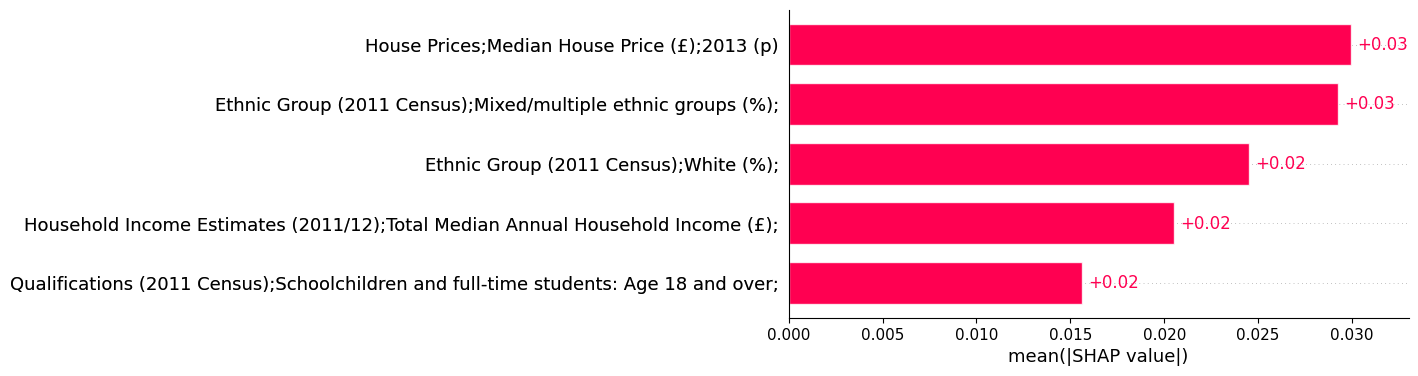

In [86]:
shap.plots.bar(shap_values)

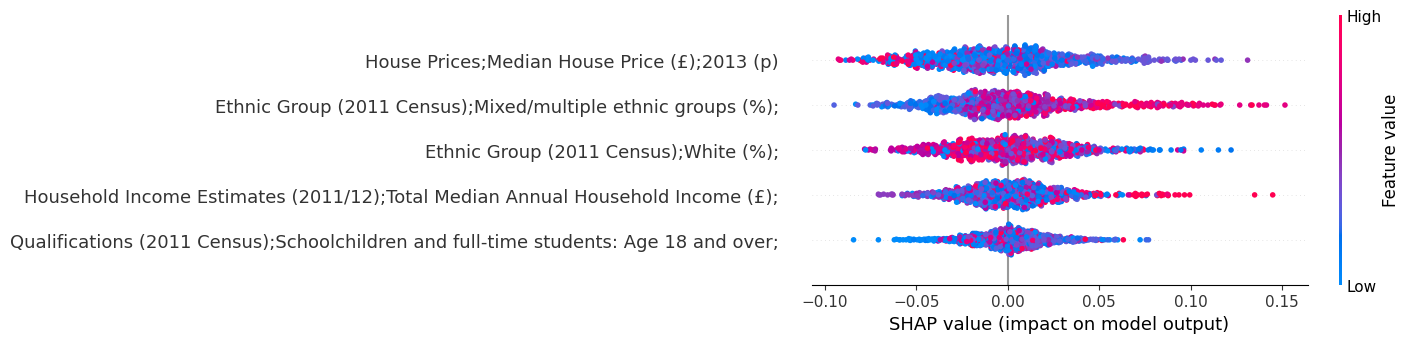

In [87]:
shap.plots.beeswarm(shap_values)

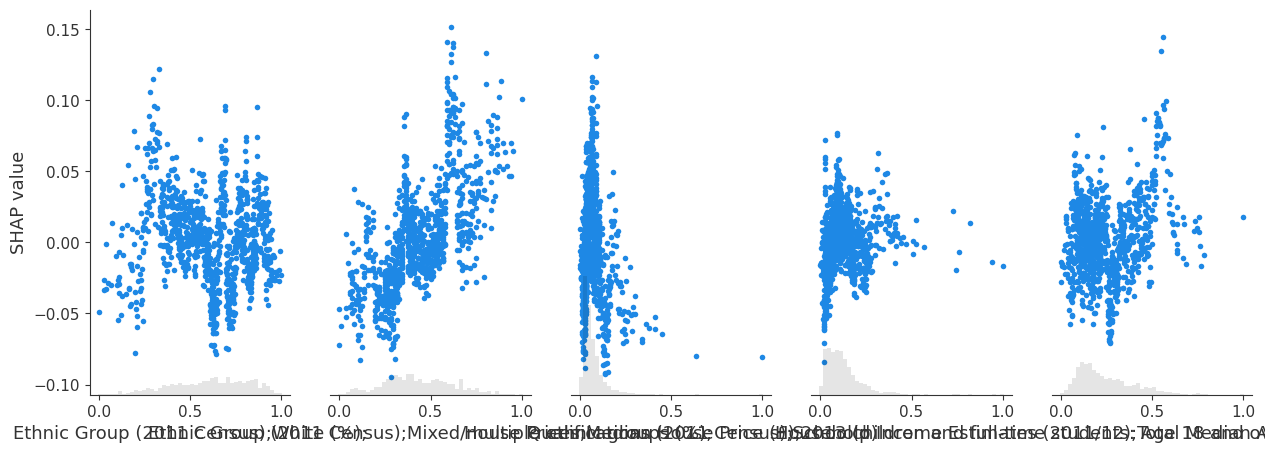

In [88]:
# plot all the scatter
shap.plots.scatter(shap_values)

In [89]:
shap.initjs()
shap.plots.force(shap_values)

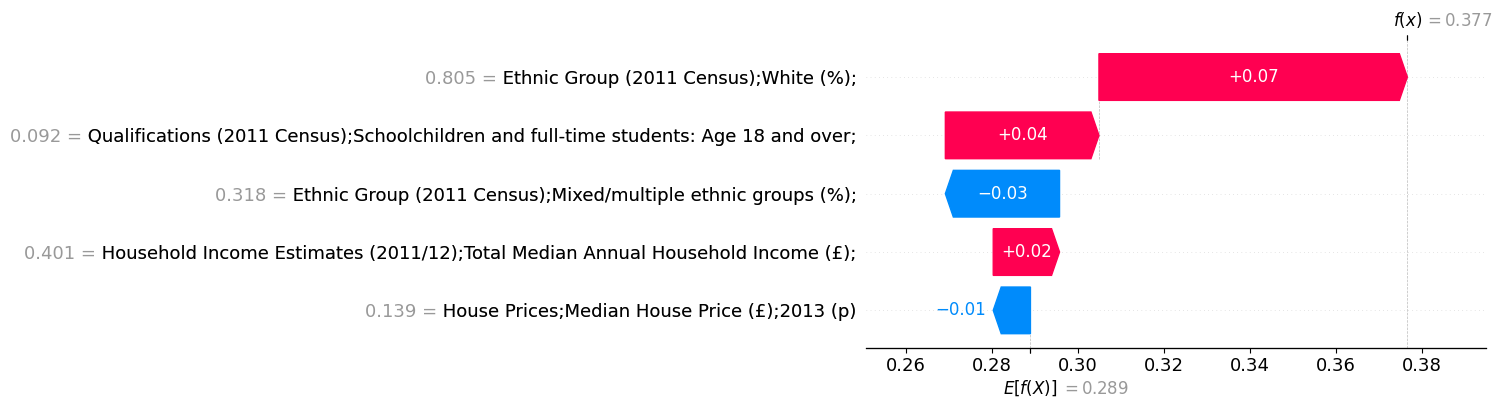

In [91]:
shap.plots.waterfall(shap_values[0])

In [92]:
shap.plots.force(shap_values[0])